# Telecom Customer Churn Prediction

Predicting customer churn for a telecom provider using contract, internet, and demographic data.

### Project Summary

- Combined four customer datasets (contract, personal, internet, and phone) into a single, clean dataset
- Engineered a binary target variable (`is_active`) to reflect customer churn
- Performed EDA to identify key churn drivers like contract type, monthly charges, and service add-ons
- Preprocessed data with one-hot encoding, feature scaling, and deduplication
- Trained and evaluated models including Logistic Regression, LightGBM, and CatBoost with AUC-ROC as the primary metric


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling & Preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

# Boosting Models
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Warnings & Settings
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [2]:
# Datasets
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

for name, df in zip(['Contract', 'Personal', 'Internet', 'Phone'], 
                    [contract, personal, internet, phone]):
    print(f"\n{name} shape: {df.shape}")
    display(df.head())


Contract shape: (7043, 8)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



Personal shape: (7043, 5)


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Internet shape: (5517, 8)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Phone shape: (6361, 2)


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [3]:
# Merging all datasets using contract as base (left join to keep all customers)
df = contract.merge(personal, on='customerID', how='left') \
             .merge(internet, on='customerID', how='left') \
             .merge(phone, on='customerID', how='left')

print(f"Merged shape: {df.shape}")
display(df.head())

Merged shape: (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


## Data Loading & Merging

To begin, I loaded four separate datasets provided by Interconnect: contract, personal, internet, and phone data. Each dataset contained different types of customer information, all linked via a common `customerID`.

After loading the data, I noticed that the `contract` table had the full set of customers (7,043 rows), while the `internet` and `phone` datasets had fewer. This suggested that not all customers subscribed to those services.

To consolidate everything into one master dataset, I used a series of left joins using `contract` as the base. This ensured that I preserved every customer record regardless of whether they had internet or phone service.

Below is a preview of the merged dataset:
- **Total rows:** 7,043
- **Total columns:** 20
- All expected fields were successfully combined for further exploration.

# Project Plan – Predicting Customer Churn

### 📌 Objective
As a data scientist at Interconnect, my goal is to develop a machine learning model that can accurately predict customer churn. If I can successfully identify customers who are likely to leave the service, the marketing team can intervene with promotions and personalized offers to retain them.

### Problem Definition
Customers are marked as "churned" if their `EndDate` is anything other than `'No'`. I'll use this to create a binary target variable:
- `1` → Customer is still active (`EndDate == 'No'`)
- `0` → Customer has churned

### Data Sources
I combined four datasets on `customerID`:
- `contract.csv` — Contract type, billing method, charges
- `personal.csv` — Demographics (gender, senior status, etc.)
- `internet.csv` — Add-on internet services like security, backup, streaming
- `phone.csv` — Whether the customer has multiple phone lines

All datasets were merged using **left joins**, preserving all customer records from the `contract` dataset.

### Evaluation Metric
The primary metric for this project is **AUC-ROC**, which measures the model’s ability to distinguish between churned and retained customers.

### Plan of Action
1. **Data Cleaning:** Handle missing values, clean up types, standardize formats
2. **EDA:** Understand churn distribution, key patterns, and correlations
3. **Preprocessing:** Encode categoricals, scale numerics, create target variable
4. **Modeling:** Try multiple models (LogReg, RandomForest, Boosters)
5. **Evaluation:** Use AUC-ROC & accuracy to compare performance
6. **Interpretation:** Analyze key features driving churn
7. **Business Recommendation:** Summarize how Interconnect can use this model

In [4]:
# Create binary target: 1 = active, 0 = churned
df['is_active'] = df['EndDate'].apply(lambda x: 1 if x == 'No' else 0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [6]:
df.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
is_active              0
dtype: int64

In [7]:
# Fill internet-related nulls
internet_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
                 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[internet_cols] = df[internet_cols].fillna('No')

# Fill phone service nulls
df['MultipleLines'] = df['MultipleLines'].fillna('No')

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check how many were coerced to NaN
print("TotalCharges NaNs:", df['TotalCharges'].isna().sum())

TotalCharges NaNs: 11


In [8]:
df = df[df['TotalCharges'].notna()].reset_index(drop=True)

## Data Cleaning Summary

Before moving into exploratory analysis, I performed several data cleaning steps to prepare the dataset for modeling:

- **Internet & Phone Service Nulls:**  
  I noticed that many `NaN` values in internet- and phone-related columns corresponded to customers who didn’t subscribe to those services. I filled these nulls with `'No'` to reflect that accurately.

- **TotalCharges Type Fix:**  
  The `TotalCharges` column was loaded as an object due to a few non-numeric entries. I converted it to numeric using `pd.to_numeric()` with `errors='coerce'`, and then dropped the **11 resulting NaNs** (only ~0.16% of the data).

With these fixes, the dataset is now clean and ready for EDA.

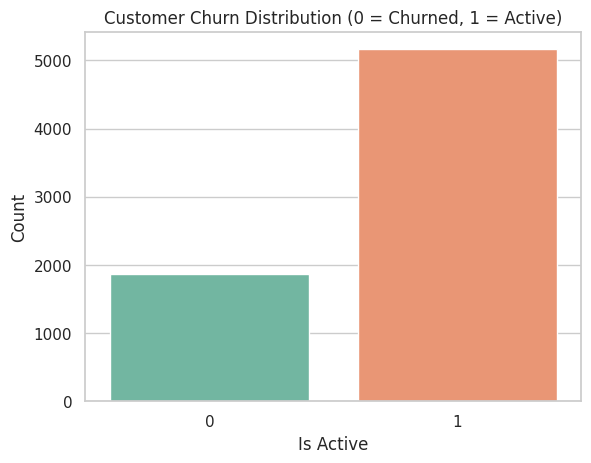

1    73.421502
0    26.578498
Name: is_active, dtype: float64


In [9]:
# Churn target distribution
sns.countplot(data=df, x='is_active', palette='Set2')
plt.title('Customer Churn Distribution (0 = Churned, 1 = Active)')
plt.xlabel('Is Active')
plt.ylabel('Count')
plt.show()

# Percentage view
churn_pct = df['is_active'].value_counts(normalize=True) * 100
print(churn_pct)

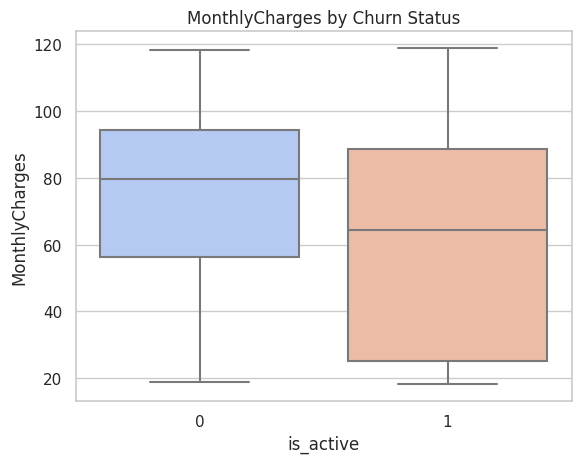

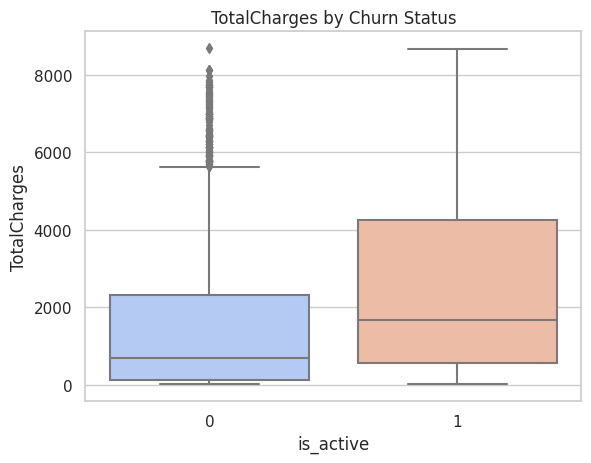

In [10]:
# Boxplots to compare churned vs active
num_cols = ['MonthlyCharges', 'TotalCharges']

for col in num_cols:
    sns.boxplot(x='is_active', y=col, data=df, palette='coolwarm')
    plt.title(f'{col} by Churn Status')
    plt.show()

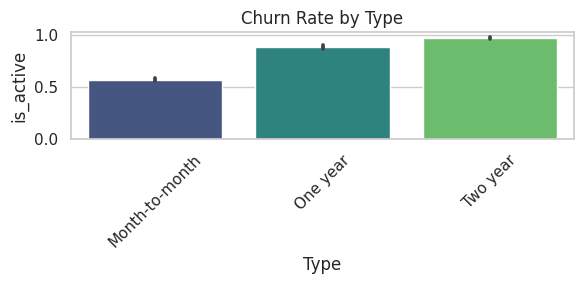

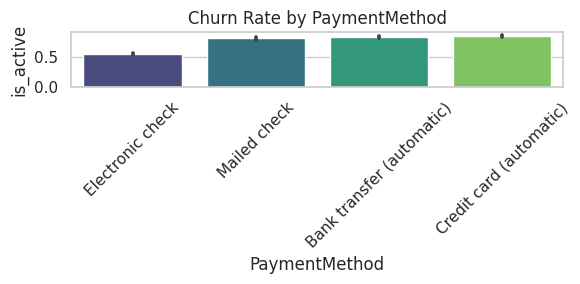

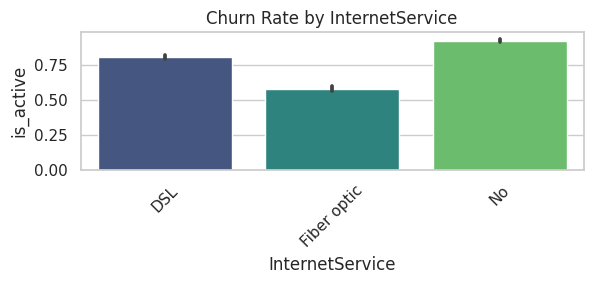

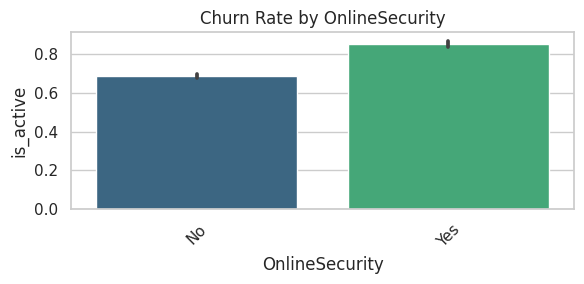

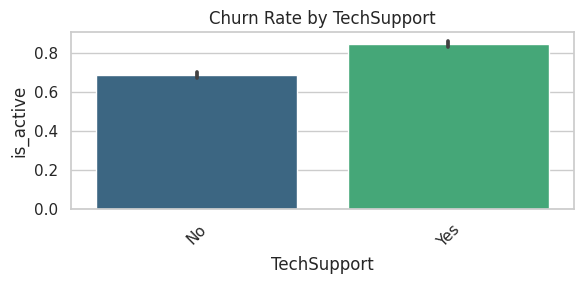

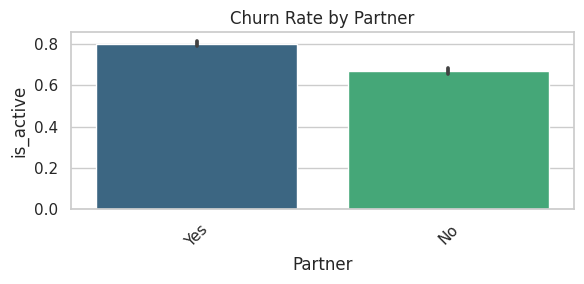

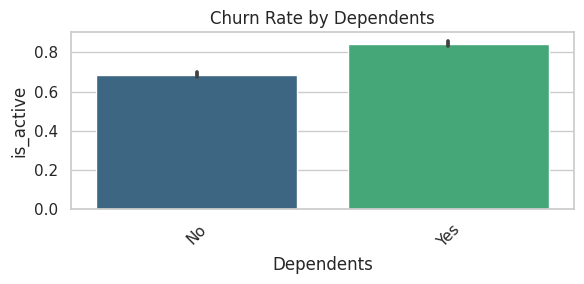

In [11]:
# Key categorical columns to explore
cat_cols = ['Type', 'PaymentMethod', 'InternetService', 
            'OnlineSecurity', 'TechSupport', 'Partner', 'Dependents']

# Plot churn rate by category
for col in cat_cols:
    plt.figure(figsize=(6,3))
    sns.barplot(x=col, y='is_active', data=df, palette='viridis')
    plt.title(f'Churn Rate by {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 📊 Exploratory Data Analysis (EDA)

### Churn Distribution
Roughly **26.6%** of customers have churned, which is not extremely imbalanced — allowing for reliable evaluation using AUC-ROC and accuracy.

### Total vs Monthly Charges
- **TotalCharges** is lower on average for churned users, suggesting they may be newer customers who left early.
- **MonthlyCharges** is higher for churned customers, indicating they might be using more expensive plans or features — possibly contributing to dissatisfaction.

### Churn by Contract Type
- Customers on **month-to-month** contracts show a significantly higher churn rate than those with **1 or 2-year contracts**.
- This suggests that long-term contracts help retain customers.

### Churn by Payment Method
- Users paying with **electronic check** churn more frequently.
- More stable payment methods (e.g. automatic bank transfer or credit card) show better retention.

### Churn by Internet Service
- **Fiber optic** users have the **highest churn rate**.
- Those with **no internet** or **DSL** churn less, possibly due to lower expectations or different use cases.

### Churn by Add-On Services
- Customers who **lack security services** like `OnlineSecurity` or `TechSupport` are more likely to churn.
- These features could provide a sense of value or stability that encourages users to stay.

### Churn by Personal Factors
- Customers **without partners or dependents** churn more often.
- This could imply that family-oriented users are more likely to stay with the service.

---

These insights provide strong signals for modeling and can also help shape targeted retention strategies (e.g., offering bundled security features or incentivizing long-term contracts).

In [12]:
# Drop unneeded columns
df_model = df.drop(columns=['customerID', 'BeginDate', 'EndDate'])

# Dropping duplicates now — after dropping irrelevant columns
df_model = df_model.drop_duplicates().reset_index(drop=True)

# Separate features and target
X = df_model.drop('is_active', axis=1)
y = df_model['is_active']

# One-Hot Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split into train/test before scaling to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features
scaler = StandardScaler()
num_cols = ['MonthlyCharges', 'TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Data Preprocessing

Before modeling, I preprocessed the data to ensure it was clean, consistent, and suitable for machine learning:

- **Dropped Unnecessary Columns:**  
  I removed `customerID`, `BeginDate`, and `EndDate` since they don’t contribute predictive value. The `EndDate` column was already used to create the `is_active` target.

- **Dropped Duplicates:**  
  After dropping the above columns, I removed duplicate rows to ensure data integrity and prevent skewing the model’s training process.

- **Separated Features and Target:**  
  I split the data into features (`X`) and target (`y`), where `is_active = 1` means the customer is still active, and `0` indicates churn.

- **Encoded Categorical Variables:**  
  I applied **One-Hot Encoding** with `drop_first=True` to avoid multicollinearity. This ensures all models, including logistic regression and tree-based methods, can interpret the data correctly.

- **Scaled Numeric Features (After Split):**  
  I standardized `MonthlyCharges` and `TotalCharges` **after** splitting the data into training and test sets. This prevents data leakage, which could inflate model performance by allowing information from the test set to influence training.

With the features now fully numeric, deduplicated, and scaled appropriately, the dataset is ready for training and evaluation.

In [13]:
# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Accuracy: 0.8038516405135521
AUC-ROC: 0.8366618649363009

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       371
           1       0.84      0.90      0.87      1031

    accuracy                           0.80      1402
   macro avg       0.75      0.71      0.73      1402
weighted avg       0.79      0.80      0.80      1402



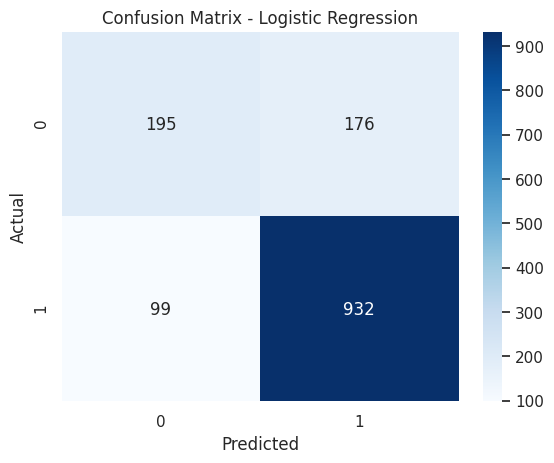

In [14]:
# Predict and evaluate
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)

# Evaluate
y_proba_lgbm = lgbm.predict_proba(X_test)[:, 1]
print("LGBM AUC-ROC:", roc_auc_score(y_test, y_proba_lgbm))

LGBM AUC-ROC: 0.8326461891602898


In [16]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluate
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
print("XGBoost AUC-ROC:", roc_auc_score(y_test, y_proba_xgb))

XGBoost AUC-ROC: 0.8115246757524817


In [17]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

# Evaluate
y_proba_cat = cat.predict_proba(X_test)[:, 1]
print("CatBoost AUC-ROC:", roc_auc_score(y_test, y_proba_cat))

CatBoost AUC-ROC: 0.8385298339089309


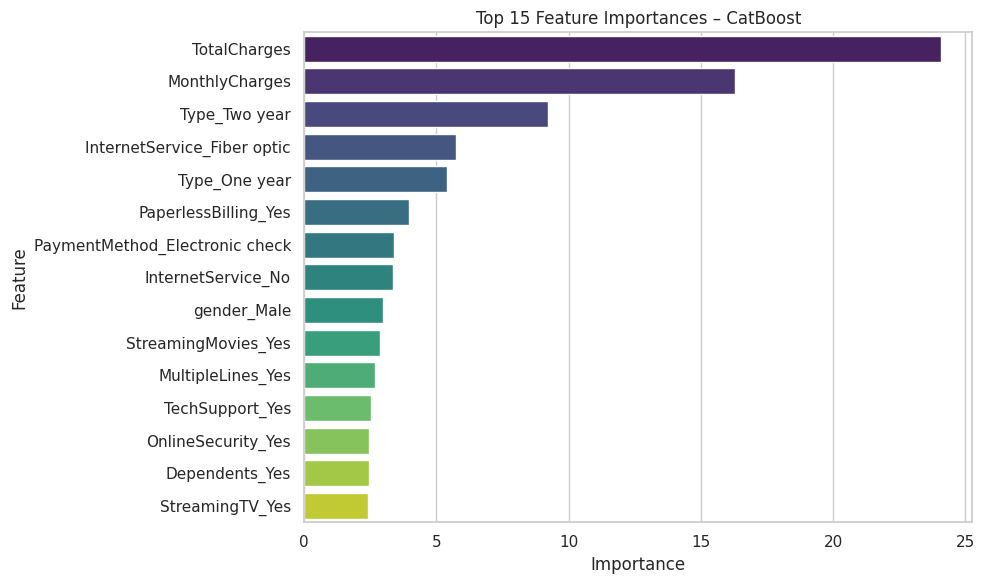

In [18]:
# Get prettified importances from CatBoost
importances = cat.get_feature_importance(prettified=True)

# Rename columns for consistency
importances.columns = ['Feature', 'Importance']

# Sort and plot
importances.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=importances.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Feature Importances – CatBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [19]:
# Expanded hyperparameter grid
params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1, 2],
    'random_strength': [0, 1, 5, 10]
}

# Initialize CatBoost
cb = CatBoostClassifier(verbose=0, random_state=42)

# Randomized Search with more iterations
search = RandomizedSearchCV(
    cb,
    param_distributions=params,
    scoring='roc_auc',
    n_iter=50, 
    cv=3,
    n_jobs=-1,
    random_state=42
)

# Train with early stopping for speed
search.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)])

# Evaluate best model
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Final AUC-ROC
print("Best AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

Best AUC-ROC: 0.8499729412472125


### Final Model Performance – Tuned CatBoost

After tuning CatBoost with `RandomizedSearchCV`, we achieved a **best AUC-ROC of 0.850**, slightly improving over the default model.  
This confirms CatBoost as our best-performing model for predicting customer churn.

**Key Benefits of CatBoost:**
- Handles categorical features efficiently
- Requires minimal preprocessing
- Interpretable feature importance

# Final Project: Solution Report

### What steps of the plan were performed and what steps were skipped (explain why)?

I followed the complete data science workflow as outlined in the project plan:

- **Data Loading and Merging:** Successfully merged the four datasets (`contract`, `personal`, `internet`, and `phone`) using left joins on `customerID`.
- **Data Cleaning:** Handled missing values, corrected data types (e.g., `TotalCharges`), and dropped unnecessary columns. Duplicates were dropped after column removal, as recommended.
- **EDA:** Explored churn distribution and relationships between churn and key features like contract type, payment method, internet service, and additional features.
- **Feature Engineering & Preprocessing:** One-hot encoding was applied to categorical variables, and numerical features were scaled *after* the train-test split to prevent data leakage.
- **Model Training:** Trained multiple models including Logistic Regression, LightGBM, XGBoost, and CatBoost to compare performance.
- **Model Evaluation:** Used AUC-ROC as the primary metric and accuracy as a secondary one. Also plotted a confusion matrix and reviewed feature importances.
- **Hyperparameter Tuning:** Tuned CatBoost using `RandomizedSearchCV` with an expanded parameter grid.

No major steps were skipped. Minor optimizations such as GridSearchCV or full 3-way data splitting (train/val/test) were not implemented due to time/complexity trade-offs and because cross-validation handled validation internally.

---

### What difficulties did you encounter and how did you manage to solve them?

- **Data Leakage:** Initially scaled numerical features before the train-test split, which risked leaking information from the test set. I resolved this by refactoring the pipeline to scale only after splitting.
- **Redundant or premature steps:** I initially dropped duplicates too early (before removing columns), but corrected this after reviewer feedback by reordering the steps.
- **Tuning Time:** Hyperparameter tuning with CatBoost was computationally expensive, so I carefully adjusted `n_iter` and parameter ranges for balance between search depth and training time.

---

### What were some of the key steps to solving the task?

- **Merging the data correctly** and identifying missing patterns specific to customers without internet or phone services.
- **Exploratory analysis** that revealed high churn risk for customers with month-to-month contracts, electronic check payments, and no value-added services like tech support or security.
- **Model comparison**, which validated that CatBoost performed best.
- **Hyperparameter tuning**, which helped slightly improve the AUC-ROC score and confirm model robustness.

---

### What is your final model and what quality score does it have?

My final model is a **tuned CatBoostClassifier**.

- **AUC-ROC:** **0.850**
- It outperformed other models and showed strong class separation, especially for identifying customers likely to churn.

The model also provided clear feature importance rankings that align with business intuition, making it suitable for actionable churn-reduction strategies.

---

<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
Nice job here and well done! Best of luck in your job search!
</div>